In [1]:
# Acá van las librerías que vamos a ocupar :)
import numpy as np                           # Útil para procesos matemáticos
from sympy import *                          # Útil para calcular derivadas  
import matplotlib.pyplot as plt              # Plotting 

## Proyecto Tarea 3

El objetivo de este proyecto es demostrar númericamente el Lema de Itô, dado por la siguiente expresión vista en clases:

$$ F(X(t))-F(X(0))=\int_0^t \frac{dF}{dX}dX+\frac{1}{2}\int_0^t \frac{d^2F}{dX^2}dt', $$

tal que abos lados distribuyan igual. Nuestro codigo dbee recibir $F(X)$, $X(0)$ y t y entregar dos histogramas correspondientes a los resultados de ambos lados. Esta vez no voy a hacer una interfaz para esto porque no hay tiempo :P.

Partimos por generar y guardar N=10000 realizaciones de $X(t)$ para la discretización del tiempo $\Delta t=10^{-4}$, para $0<t<1$ (10.000 pasos).

Cada iteración será tal que el i-esimo paso puede ser expresado como $x_i=x_{i-1}+dx$, donde $dx=n\cdot \sigma=n\cdot\sqrt{\Delta t}$ con $n$: número generado anteriormente para una distribución normal con $\mu=0$ y $\sigma=1$. 

Como en la tarea pasada modelamos este modelo, y como no se optimizar bien este proceso para que no tome días, voy a tomar presatda una realización por Tirthajyoti Sarkar en su blog en towardsdatascience.com. 


In [2]:
# Codigo basado en https://towardsdatascience.com/brownian-motion-with-python-9083ebc46ff0 
# Adaptado por mí para generar pasos distribuidos X ~ N(0,1)
# Clase Generadora de movimiento Browniano
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self, N=1000, x0=0, steps=10000):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
        self.N = N
        self.random_walks = [self.gen_random_walk(steps) for _ in range(0,N)]
        self.random_walks_t_half = [(rw[0][:len(rw[0])//2], rw[1][:len(rw[1])//2]) for rw in self.random_walks]
        self.dt = 1/steps

    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        y = np.ones(n_step)*self.x0
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            y[i] = yi
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return (w,y)
    
    # Funciones para demostrar Ito:
    def data_lado_izquierdo(self, f):
        last_entry_rws = [rw[0][-1] for rw in self.random_walks]
        return [f(d)-f(self.x0) for d in last_entry_rws]
    
    def data_lado_derecho(self, f1, f2):
        dt = self.dt
        sum_results = []
        for rw in self.random_walks:
            pre_sum = np.array([f1(rw[0][i])*(rw[1][i]*np.sqrt(dt))+0.5*f2(rw[0][i])*(rw[1][i]*np.sqrt(dt))**2 for i in range(0,len(rw))])
            sum_results.append(np.sum(pre_sum))
        return sum_results

    def data_lado_izquierdo2(self, f):
        last_entry_rws = [rw[0][-1] for rw in self.random_walks_t_half]
        return [f(d)-f(self.x0) for d in last_entry_rws]
    
    def data_lado_derecho2(self, f1, f2):
        dt = self.dt
        sum_results = []
        for rw in self.random_walks_t_half:
            pre_sum = np.array([f1(rw[0][i])*(rw[1][i]*np.sqrt(dt))+0.5*f2(rw[0][i])*(rw[1][i]*np.sqrt(dt))**2 for i in range(0,len(rw))])
            sum_results.append(np.sum(pre_sum))
        return sum_results

In [3]:
# Voy a generar y guardar N realizaciónes de 10.000 pasos (~6:20 min aprox)
N = 10000                             # Realizaciones
b = Brownian(N=N, x0=0)               # Definir aquí x0
random_walks = b.random_walks

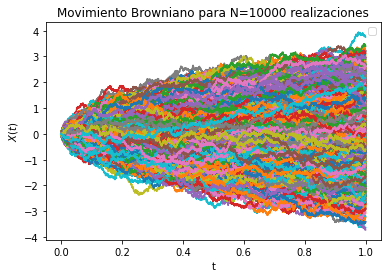

In [4]:
# Plot de random walks generadas (~1:20 min aprox)
fig, ax = plt.subplots()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ts = np.arange(0,1, 0.0001)
for rw in random_walks:
    ax.plot(ts, rw[0])

ax.set_title('Movimiento Browniano para N={} realizaciones'.format(N))
ax.set_ylabel(r'$X(t)$')
ax.set_xlabel(r't')
plt.show()

Vamos ahora con la segunda parte del problema. El lado derecho es bastante directo de calcular con nuestos datos discretos. Para el lado izquierdo debemos aproximar las integrales a sumatorías tal que: 

$$ \int_0^t \frac{dF}{dX}dX+\frac{1}{2}\int_0^t \frac{d^2F}{dX^2}dt' \approx \sum^n_{i=0}\left[ \frac{dF}{dX}\left|_{x=x_i}dx_i + \frac{1}{2}\frac{d^2F}{dX^2}\right|_{x=x_i}dt_i\right], $$

con $n$: pasos en realización ($n$=10.000 en nuestro caso). En clases vimos como $dt=dx^2$, lo que nos lleva a escribir lo anterior de la siguiente manera:

$$ \int_0^t \frac{dF}{dX}dX+\frac{1}{2}\int_0^t \frac{d^2F}{dX^2}dt' \approx \sum^n_{i=0}\left[ \frac{dF}{dX}\left|_{x=x_i}(n_i\cdot\sqrt{\Delta t}) + \frac{1}{2}\frac{d^2F}{dX^2}\right|_{x=x_i}(n_i\cdot\sqrt{\Delta t})^2\right]. $$

Hagamos los histogramas correspondientes para cada lado de la ecuación. Partimos por definir nuestra función $F(x)$ y en base a eso la clase es capaz de calcular ambos lados del lema de Ito, para $t=1$ y $t=0.5$. Abajo despliego los histogramas correspondientes para cada función pedida.  

<ipython-input-5-13f3c82733d6>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-13f3c82733d6>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


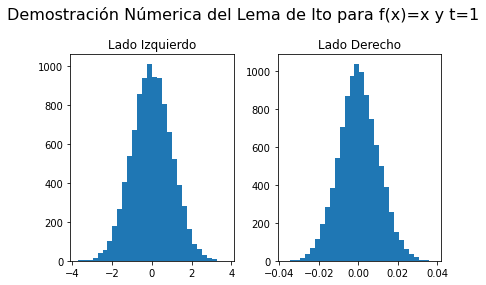

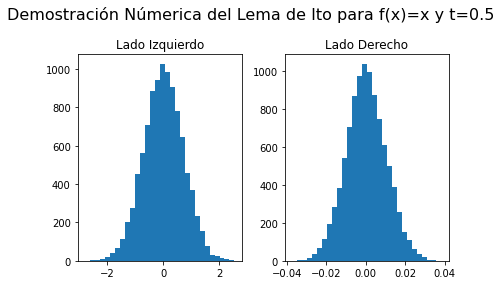

In [5]:
# Acá defino el X(0) y la función que podemos variar para el problema
x = Symbol('x')
f_original = x              # Definir F(x) aquí 

# Derivamos y convertimos a funciónes con las que python pueda trabajar
f1 = f_original.diff(x)
f2 = f1.diff(x)
f, f1, f2 = lambdify(x, f_original, 'numpy'), lambdify(x, f1, 'numpy'), lambdify(x, f2, 'numpy')

# Gráficamos t = 1
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo(f), bins=30)
ax[1].hist(b.data_lado_derecho(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=1'.format(f_original), fontsize=16)
fig.tight_layout()
fig.show()

# Gráficamos t = 0.5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo2(f), bins=30)
ax[1].hist(b.data_lado_derecho2(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=0.5'.format(f_original), fontsize=16)
fig.tight_layout()
fig.show()



<ipython-input-6-7f9dae123c7e>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


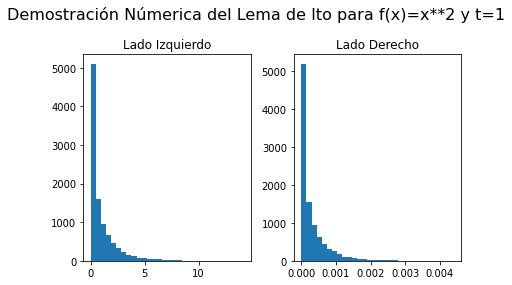

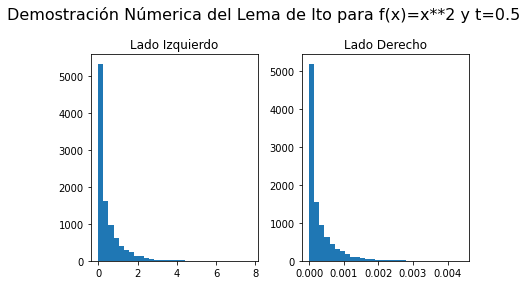

In [6]:
# Acá defino el X(0) y la función que podemos variar para el problema
x = Symbol('x')
f_original = x**2              # Definir F(x) aquí 

# Derivamos y convertimos a funciónes con las que python pueda trabajar
f1 = f_original.diff(x)
f2 = f1.diff(x)
f, f1, f2 = lambdify(x, f_original, 'numpy'), lambdify(x, f1, 'numpy'), lambdify(x, f2, 'numpy')

# Gráficamos t = 1
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo(f), bins=30)
ax[1].hist(b.data_lado_derecho(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=1'.format(f_original), fontsize=16)
fig.tight_layout()

# Gráficamos t = 0.5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo2(f), bins=30)
ax[1].hist(b.data_lado_derecho2(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=0.5'.format(f_original), fontsize=16)
fig.tight_layout()
fig.show()


<ipython-input-7-547811187b70>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


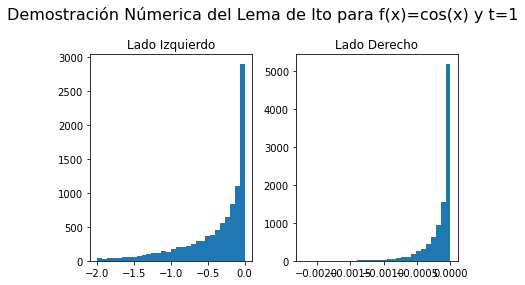

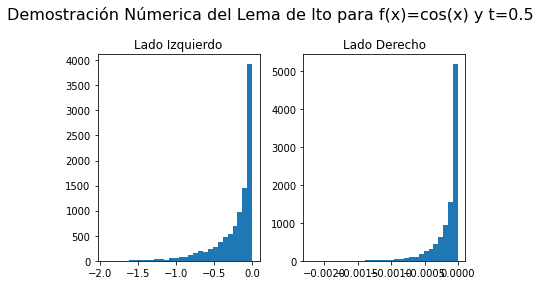

In [7]:
# Acá defino el X(0) y la función que podemos variar para el problema
x = Symbol('x')
f_original = cos(x)              # Definir F(x) aquí 

# Derivamos y convertimos a funciónes con las que python pueda trabajar
f1 = f_original.diff(x)
f2 = f1.diff(x)
f, f1, f2 = lambdify(x, f_original, 'numpy'), lambdify(x, f1, 'numpy'), lambdify(x, f2, 'numpy')

# Gráficamos t = 1
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo(f), bins=30)
ax[1].hist(b.data_lado_derecho(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=1'.format(f_original), fontsize=16)
fig.tight_layout()

# Gráficamos t = 0.5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo2(f), bins=30)
ax[1].hist(b.data_lado_derecho2(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=0.5'.format(f_original), fontsize=16)
fig.tight_layout()
fig.show()


Vemos en los gráficos de barras para todas las funciones que el lado izquierdo distribuye muy parecido a como distribuye el lado derecho, independiente de los valores númericos en los que fluctua toma cada extremo.

Podemos atribuir la diferencia entre ambos a la aproximación de las integrales a sumatorias discretas. Siendo este el caso, deberíamos esperar que al aumentar el numero de datos, los lados converjan cada vez más. Es por esto que podemos asegurar que, para más realizaciónes, la diferencia entre histogramas tenderá a 0.    

En cuanto a las diferencias por tomar $t$ mayor o menor, vemos como los histogramas tienden a parecerse más para menor $t$. Esto lo explicamos nuevamente por tomar variables discretas; la varianza escala con $t$, por lo que la dispersión de los datos támbien escalará proporcional al tiempo y, dada variables discretas simuladas, la varianza de los histogramas lo hara de igual manera.

Dejo abajo una celda para que corran estas simulaciones para una función distinta. Tengan en mente que los componentes de esta tiene que estar definidos en la libreria Sympy de python. Cuidado con funciones cuyas derivadas se indeterminen en $X\in[-4,4]$ :D

<ipython-input-10-b7f18c467e54>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


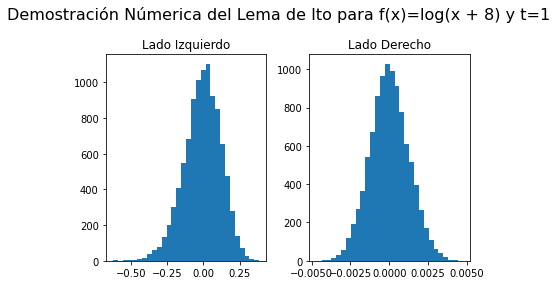

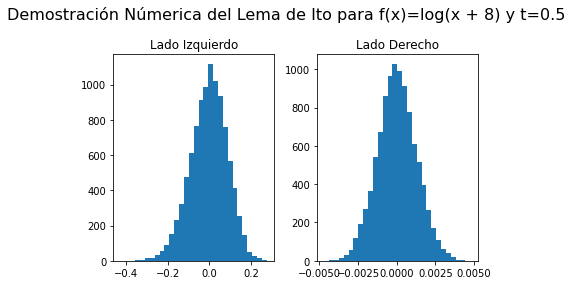

In [10]:
# Acá defino el X(0) y la función que podemos variar para el problema
x = Symbol('x')
f_original = ln(x+8)              # Definir F(x) aquí 

# Derivamos y convertimos a funciónes con las que python pueda trabajar
f1 = f_original.diff(x)
f2 = f1.diff(x)
f, f1, f2 = lambdify(x, f_original, 'numpy'), lambdify(x, f1, 'numpy'), lambdify(x, f2, 'numpy')

# Gráficamos t = 1
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo(f), bins=30)
ax[1].hist(b.data_lado_derecho(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=1'.format(f_original), fontsize=16)
fig.tight_layout()

# Gráficamos t = 0.5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(b.data_lado_izquierdo2(f), bins=30)
ax[1].hist(b.data_lado_derecho2(f1, f2), bins=30)
ax[0].set_title('Lado Izquierdo')
ax[1].set_title('Lado Derecho')
fig.suptitle('Demostración Númerica del Lema de Ito para f(x)={} y t=0.5'.format(f_original), fontsize=16)
fig.tight_layout()
fig.show()